# Introducción

Las Redes Neuronales de Memoria a Largo Plazo (LSTM) son una arquitectura de redes neuronales recurrentes especialmente diseñada para el análisis de series temporales multivariables. Estas redes permiten capturar y retener dependencias temporales a largo plazo, evitando problemas de desvanecimiento de gradientes, gracias a su estructura de celdas con puertas de control. En el contexto de series temporales con múltiples variables, las LSTM pueden procesar datos de entrada de diversas fuentes en paralelo, lo que las convierte en una herramienta poderosa para modelar relaciones complejas y predecir con precisión en aplicaciones que abarcan desde finanzas hasta pronósticos climáticos y análisis de datos en tiempo real.

*Long Short-Term Memory (LSTM) networks are a specialized recurrent neural network architecture designed for the analysis of multivariate time series data. LSTMs excel at capturing and retaining long-term temporal dependencies, mitigating gradient vanishing issues through their gated cell structure. In the context of multivariate time series, LSTMs can process input data from various sources in parallel, making them a powerful tool for modeling complex relationships and achieving accurate predictions in applications ranging from finance to weather forecasting and real-time data analysis.*

## Carga de librerías

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import itertools
import random
import os

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('df_BTC_MAs_and_RSI.csv',
            index_col = "date",
            parse_dates = True).asfreq("D")
df.head()

,original_series,diff,sqrt,inverse,log,squared,cubic,boxcox,yeo-johnson,MA25,MA50,EMA100,RSI
date,,,,,,,,,,,,,
2010-09-05,0.06160,-0.00078,0.248193,16.233766,-2.787093,0.003795,0.394936,-1.969850,-1.757090,0.065128,0.064282,0.058836,38.030468
2010-09-06,0.06100,0.00000,0.248193,16.233766,-2.787093,0.003795,0.394936,-1.969850,-1.757090,0.064912,0.064524,0.058891,40.427993
2010-09-07,0.06200,-0.00060,0.246982,16.393443,-2.796881,0.003721,0.393650,-1.970768,-1.757177,0.064576,0.064039,0.058945,38.764045
2010-09-08,0.06111,0.00100,0.248998,16.129032,-2.780621,0.003844,0.395789,-1.969243,-1.757031,0.064436,0.063643,0.058985,42.473118
2010-09-09,0.06180,-0.00089,0.247204,16.363934,-2.795080,0.003734,0.393886,-1.970599,-1.757161,0.064236,0.063388,0.059045,42.268593


## *Split, Normalization and Time Series Generator*

In [3]:
#Normalization with MinMaxScaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df)

In [4]:
#We separate the normalized data into independent variables and the target.
features=data_scaled
target=data_scaled[:,0]

Los datos de series temporales deben transformarse en una estructura de muestras con componentes de entrada y salida antes de poder utilizarse para ajustar un modelo de aprendizaje supervisado.

Esto puede ser desafiante si tienes que realizar esta transformación manualmente. La biblioteca de aprendizaje profundo Keras proporciona el TimeseriesGenerator para transformar automáticamente datos de series temporales univariadas y multivariadas en muestras, listas para entrenar modelos de aprendizaje profundo.

*Los datos de series temporales deben transformarse en una estructura de muestras con componentes de entrada y salida antes de poder utilizarse para ajustar un modelo de aprendizaje supervisado.*

*Esto puede ser desafiante si tienes que realizar esta transformación manualmente. La biblioteca de aprendizaje profundo Keras proporciona el TimeseriesGenerator para transformar automáticamente datos de series temporales univariadas y multivariadas en muestras, listas para entrenar modelos de aprendizaje profundo.*

In [5]:
generator = TimeseriesGenerator(features, target, length=2, sampling_rate=1, batch_size=32)

Además de especificar los aspectos de entrada y salida de nuestro problema de series temporales, hay algunos parámetros adicionales que debemos configurar; por ejemplo:

longitud: El número de observaciones rezagadas que se utilizarán en la parte de entrada de cada muestra.

batch_size: El número de muestras que se devolverán en cada iteración.

Podemos definir el tamaño del lote (batch size) como el tamaño del lote de nuestro modelo durante el entrenamiento. Si el número de muestras en nuestro conjunto de datos es menor que el tamaño del lote, podemos establecer el tamaño del lote en el generador y en nuestro modelo como el número total de muestras en el generador.

*In addition to specifying the input and output aspects of our time series problem, there are some additional parameters that we need to configure, for example:*

- **Length:** *The number of lag observations to be used in the input part of each sample.*

- **Batch size:** *The number of samples that will be returned in each iteration.*

*We can define the batch size as the batch size of our model during training. If the number of samples in our dataset is smaller than the batch size, we can set the batch size in the generator and in our model as the total number of samples in the generator.*

In [6]:
print(len(generator))

149


In [7]:
#Now we split the data
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle = False)

preparamos los generadores de datos de series temporales para entrenar y evaluar nuestro modelo:

*We prepare the time series data generators to train and evaluate our model:*

In [8]:
win_length=300 # longitud de las secuencias de tiempo que se generarán a partir de los datos de entrada
num_features=13
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=32)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=32)

## *LSTM Model*


En la primera línea, hemos inicializado un modelo vacío utilizando `tf.keras.Sequential()`. Este modelo se utilizará para construir capas secuencialmente.

Luego, hemos añadido una capa LSTM con 128 unidades. Hemos especificado la forma de entrada como `(win_length, num_features)`, lo que significa que esperamos secuencias de tiempo con una longitud de 300 y 13 características en cada paso. Además, hemos configurado `return_sequences=True`, lo que significa que esta capa devuelve secuencias en lugar de un solo valor. Esto es útil cuando se apilan capas LSTM.

A continuación, hemos añadido una capa de activación LeakyReLU con un factor de pendiente de 0.55 para introducir no linealidad en la red.

Hemos repetido los pasos 2 y 3, agregando otra capa LSTM, activación LeakyReLU y otra capa de abandono (Dropout). La capa LSTM tiene 128 unidades y también devuelve secuencias.

Después de estas capas LSTM, hemos añadido una capa de abandono (Dropout) con una tasa del 30%. Esto ayuda a prevenir el sobreajuste al apagar aleatoriamente el 30% de las unidades durante el entrenamiento.

Luego, hemos agregado una tercera capa LSTM con 64 unidades, pero esta vez hemos establecido `return_sequences=False`, lo que significa que esta capa no devuelve secuencias, sino un solo valor en la salida.

Finalmente, hemos añadido una última capa de abandono (Dropout) antes de la capa de salida, que es una capa densa (fully connected) con 1 neurona. Esta capa se utiliza comúnmente en problemas de regresión donde se espera una sola salida.



*In the first line, we have initialized an empty model using `tf.keras.Sequential()`. This model will be used to build layers sequentially.*

*Next, we added an LSTM layer with 128 units. We specified the input shape as `(win_length, num_features)`, which means we expect time sequences with a length of 300 and 13 features at each time step. Additionally, we configured `return_sequences=True`, meaning this layer returns sequences rather than a single value. This is useful when stacking LSTM layers.*

*Following that, we added a LeakyReLU activation layer with a slope factor of 0.55 to introduce nonlinearity into the network.*

*We repeated steps 2 and 3, adding another LSTM layer, LeakyReLU activation, and another Dropout layer. The LSTM layer has 128 units and also returns sequences.*

*After these LSTM layers, we added a Dropout layer with a 30% rate. This helps prevent overfitting by randomly turning off 30% of the units during training.*

*Next, we added a third LSTM layer with 64 units, but this time, we set `return_sequences=False`, meaning this layer doesn't return sequences but a single value in the output.*

*Finally, we added one last Dropout layer before the output layer, which is a dense (fully connected) layer with 1 neuron. This layer is commonly used in regression problems where a single output is expected.*

In [9]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape= (win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.55))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.55))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300, 128)          72704     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 300, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 300, 128)          131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 300, 128)          0         
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0


Hemos definido un objeto `early_stopping` como una instancia de `tf.keras.callbacks.EarlyStopping`. Esta es una técnica de parada temprana que detendrá el entrenamiento del modelo si la métrica de pérdida en el conjunto de validación (`'val_loss'`) deja de mejorar durante un número específico de épocas definido por `patience` (en este caso, 2 épocas) y en un modo de minimización (`'mode=min'`). Esto ayuda a evitar el sobreajuste y mejora la eficiencia del entrenamiento.

Hemos configurado el modelo para el entrenamiento. Utilizamos una función de pérdida de error cuadrático medio (`tf.losses.MeanSquaredError()`), el optimizador Adam (`tf.optimizers.Adam()`), y hemos especificado que queremos evaluar la métrica de error absoluto medio (`tf.metrics.MeanAbsoluteError()`).

A continuación, hemos entrenado el modelo utilizando `model.fit_generator()`. Hemos especificado el generador de datos de entrenamiento `train_generator`, un número de épocas igual a 50, el conjunto de validación `test_generator`, y hemos desactivado el mezclado de datos durante el entrenamiento con `shuffle=False`.



*We have defined an `early_stopping` object as an instance of `tf.keras.callbacks.EarlyStopping`. This is an early stopping technique that will halt the model training if the validation set's loss metric ('val_loss') stops improving for a specific number of epochs defined by `patience` (in this case, 2 epochs) and in a minimization mode ('mode=min'). This helps prevent overfitting and improves training efficiency.*

*We've configured the model for training. We used a mean squared error loss function (`tf.losses.MeanSquaredError()`), the Adam optimizer (`tf.optimizers.Adam()`), and specified that we want to evaluate the mean absolute error metric (`tf.metrics.MeanAbsoluteError()`).*

*Next, we trained the model using `model.fit_generator()`. We specified the training data generator `train_generator`, a total of 50 epochs, the validation set `test_generator`, and disabled data shuffling during training with `shuffle=False`. *

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=2,
                                                    mode='min')

model.compile(loss = tf.losses.MeanSquaredError(),
              optimizer = tf.optimizers.Adam(),
              metrics = [tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=50,
                    validation_data=test_generator,
                    shuffle=False,
                    callbacks=[early_stopping])

Epoch 1/50
110/110 [==============================] - 139s 1s/step - loss: 0.0018 - mean_absolute_error: 0.0254 - val_loss: 0.0412 - val_mean_absolute_error: 0.1855
Epoch 2/50
110/110 [==============================] - 131s 1s/step - loss: 0.0033 - mean_absolute_error: 0.0310 - val_loss: 0.0053 - val_mean_absolute_error: 0.0568
Epoch 3/50
110/110 [==============================] - 135s 1s/step - loss: 0.0015 - mean_absolute_error: 0.0263 - val_loss: 0.0118 - val_mean_absolute_error: 0.1007
Epoch 4/50
110/110 [==============================] - 134s 1s/step - loss: 7.2747e-04 - mean_absolute_error: 0.0183 - val_loss: 0.0131 - val_mean_absolute_error: 0.1080


In [11]:
model.evaluate_generator(test_generator, verbose=0)

[0.013145029544830322, 0.10804352164268494]

Graficamos la función de pérdida durante el entrenamiento:

*We plot the loss function during training.*

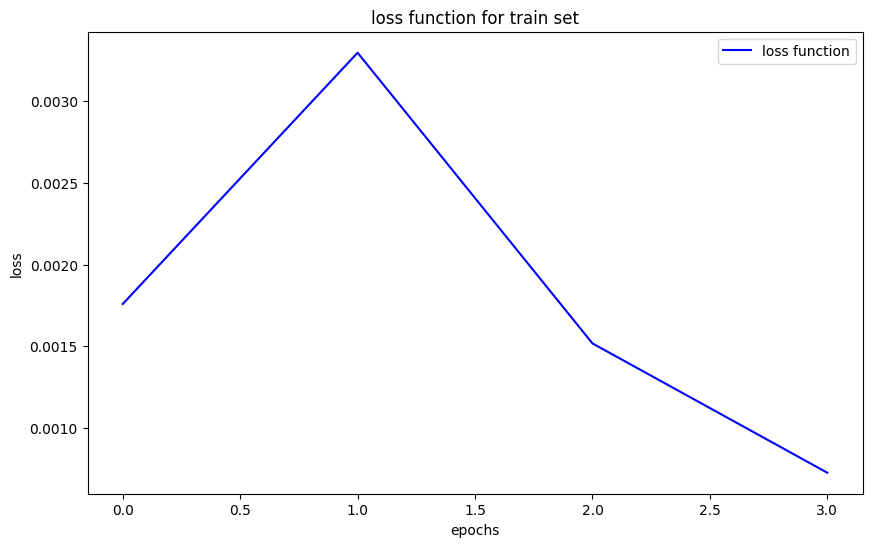

In [12]:
loss = history.history['loss']
plt.figure(figsize=(10, 6))
plt.plot(loss, label='loss function', color='blue')
plt.title('loss function for train set')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## *Predictions*

In [13]:
predictions = model.predict_generator(test_generator)

In [14]:
#We select the entire array excluding the target column and make sure it matches the number of predictions (300)
x_test[:,1:][win_length:]

array([[5.61506620e-01, 9.03208091e-01, 1.97733764e-07, ...,
        9.97881437e-01, 9.95922231e-01, 2.91155355e-01],
       [5.92831942e-01, 9.12847243e-01, 1.75187735e-07, ...,
        9.98120565e-01, 9.95973065e-01, 3.17987888e-01],
       [6.66643379e-01, 9.29173868e-01, 1.38586673e-07, ...,
        9.98524925e-01, 9.96446724e-01, 3.79501898e-01],
       ...,
       [4.88935271e-01, 6.17695754e-01, 1.41823189e-06, ...,
        4.62121653e-01, 5.06262776e-01, 4.26895565e-01],
       [5.28172704e-01, 6.22928772e-01, 1.37989493e-06, ...,
        4.60773512e-01, 5.05494151e-01, 5.02857118e-01],
       [4.67661648e-01, 6.19865953e-01, 1.40221538e-06, ...,
        4.59527531e-01, 5.04898008e-01, 4.77454874e-01]])

In [15]:
 # We merge the test set with the predictions in a new df
df_pred = pd.concat([pd.DataFrame(predictions), pd.DataFrame(x_test[:,1:][win_length:])],axis=1)

In [16]:
df_pred

,0,0,1,2,3,4,5,6,7,8,9,10,11
0,0.816777,0.561507,0.903208,1.977338e-07,0.985416,0.665772,0.933813,0.968820,0.967982,0.978441,0.997881,0.995922,0.291155
1,0.814854,0.592832,0.912847,1.751877e-07,0.986937,0.694621,0.940506,0.972033,0.971286,0.973290,0.998121,0.995973,0.317988
2,0.813325,0.666643,0.929174,1.385867e-07,0.989476,0.745610,0.951791,0.977418,0.976821,0.969000,0.998525,0.996447,0.379502
3,0.812461,0.422599,0.922975,1.522553e-07,0.988517,0.725931,0.947514,0.975381,0.974728,0.967039,0.999595,0.997639,0.423496
4,0.812401,0.466684,0.920819,1.570736e-07,0.988182,0.719179,0.946025,0.974671,0.973998,0.964618,0.999661,0.998530,0.430359
...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,0.508805,0.464483,0.617222,1.421754e-06,0.930890,0.145470,0.722552,0.859281,0.854651,0.432149,0.465136,0.507857,0.448232
647,0.509516,0.494559,0.617846,1.417117e-06,0.931035,0.146059,0.723045,0.859558,0.854940,0.429744,0.463611,0.507042,0.501964
648,0.509805,0.488935,0.617696,1.418232e-06,0.931000,0.145917,0.722926,0.859491,0.854870,0.427409,0.462122,0.506263,0.426896
649,0.509679,0.528173,0.622929,1.379895e-06,0.932208,0.150917,0.727052,0.861803,0.857276,0.425051,0.460774,0.505494,0.502857


In [17]:
#We reverse the normalization to compare with the original values
rev_trans = scaler.inverse_transform(df_pred)

In [18]:
df_final = df[predictions.shape[0]*-1:]

predictions.shape[0] representa el número de predicciones realizadas por el modelo.*-1 se utiliza para seleccionar las últimas filas del DataFrame original.

Esto se hace para coincidir con las filas de las predicciones hechas por el modelo y los datos de entrada originales que deseamos analizar.

`predictions.shape[0]` *represents the number of predictions made by the model. *`*-1` *is used to select the last rows of the original DataFrame. This is done to align the rows of the model's predictions with the original input data that we want to analyze.*

In [19]:
df_final.count()

original_series    651
diff               651
sqrt               651
inverse            651
log                651
squared            651
cubic              651
boxcox             651
yeo-johnson        651
MA25               651
MA50               651
EMA100             651
RSI                651
dtype: int64

In [20]:
#We add to the final df the inverse normalization of the prediction column
df_final['Pred'] = rev_trans[:,0]

In [21]:
df_final.head()

,original_series,diff,sqrt,inverse,log,squared,cubic,boxcox,yeo-johnson,MA25,MA50,EMA100,RSI,Pred
date,,,,,,,,,,,,,,
2021-11-27,56094.7,818.5,234.344831,0.000018,10.913587,3.015932e+09,38.010500,1.591411,1.581547,61266.492,60658.710,54776.304926,30.017413,54973.271871
2021-11-28,58117.1,1177.2,236.843197,0.000018,10.934797,3.146615e+09,38.280178,1.603234,1.592944,60943.992,60673.246,54779.100868,32.637765,54843.814536
2021-11-29,57345.0,2022.4,241.074885,0.000017,10.970215,3.377597e+09,38.734799,1.623052,1.612038,60675.324,60697.826,54805.152336,38.644963,54740.942691
2021-11-30,57077.7,-772.1,239.468161,0.000017,10.956841,3.288449e+09,38.562500,1.615558,1.604819,60552.536,60762.848,54870.735458,42.941258,54682.781165
2021-12-01,56887.6,-267.3,238.909397,0.000018,10.952169,3.257864e+09,38.502490,1.612943,1.602300,60400.980,60766.872,54919.730796,43.611462,54678.749414


Visualizemos el resultado de nuestras predicciones

*Let´s show the results of our predictions:*

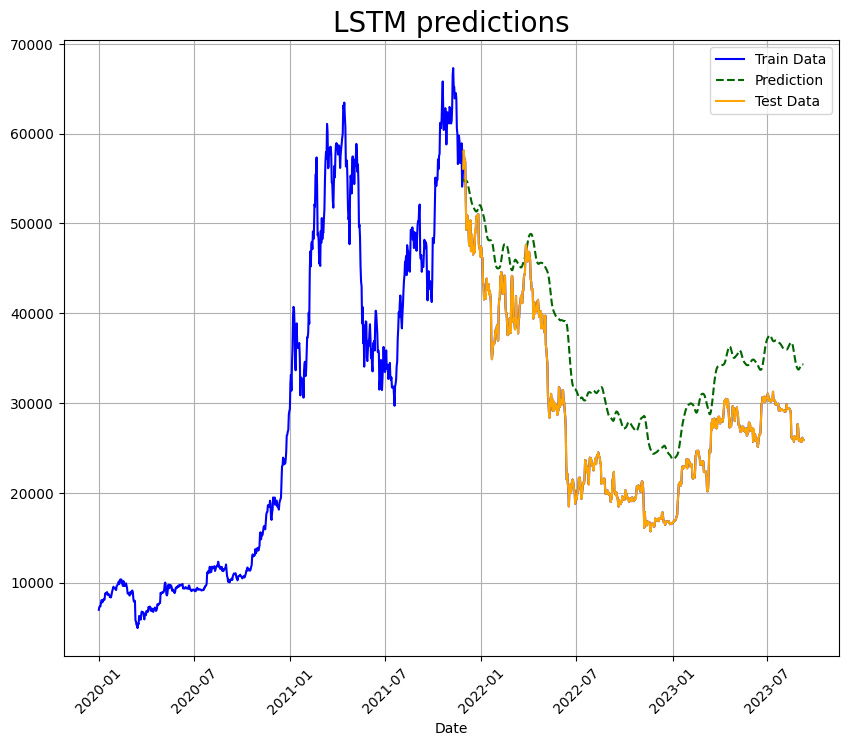

In [22]:
import datetime
import numpy as np

start_date = datetime.datetime(2020, 1, 1)

fig, ax = plt.subplots()
ax.plot(df['original_series'][start_date:], color="blue", label='Train Data')


ax.plot(
        df_final['Pred'],
        color="darkgreen",
        ls="--", label='Prediction')

ax.plot(df_final['original_series'], color = "orange", label='Test Data')
# Más personalización de la gráfica
ax = plt.gca()
ax.tick_params(axis="x", labelrotation = 45)
ax.set_title('LSTM predictions', fontsize = 20)
ax.set_xlabel("Date")
ax.grid()
ax.legend()
plt.show()

Text(0.5, 1.0, 'Comparison: Original price vs. Predictions')

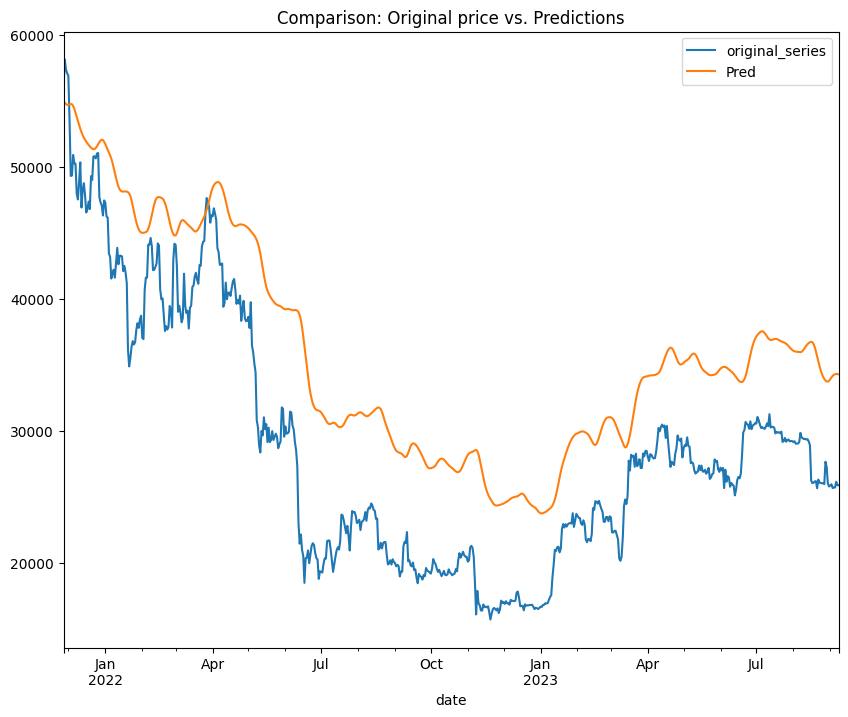

In [23]:
df_final[['original_series','Pred']].plot()
plt.title('Comparison: Original price vs. Predictions')

Evaluemos algunas métricas:

*Let´s use some metrics for evaluation:*

In [24]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

mape = mean_absolute_percentage_error(df_final['original_series'], df_final['Pred'])
mae = mean_absolute_error(df_final['original_series'], df_final['Pred'])
mse = mean_squared_error(df_final['original_series'], df_final['Pred'])

print(f'mean_absolute_percentage_error = {mape}')
print(f'mean_absolute_error = {mae}')
print(f'mean_square_error = {mse}')

mean_absolute_percentage_error = 0.29529439117108836
mean_absolute_error = 7271.874354306566
mean_square_error = 59546573.24748799


Podemos apreciar que los resultados no son del todo óptimos. Intentemos mejorarlos a partir de buscar los mejores hiperparámetros.

*We can observe that the results are not entirely optimal. Let's try to improve them by searching for the best hyperparameters.*

## GridSearch

GridSearch (búsqueda en cuadrícula) es un método tradicional para realizar ajuste de hiperparámetros. Básicamente, consiste en definir un subconjunto de valores candidatos para cada hiperparámetro y entrenar todos las posibles combinaciones de hiperparámetros. Luego, cada modelo ajustado se evalúa en un conjunto de validación, y al final se elige la mejor configuración de hiperparámetros.

*Grid search is a traditional method to perform hyperparameter tunning. It basically works by defining a subset of candidate values for each hyperparameter, and training all the possible combination of the hyperparameters. Then, each possible fitted model is evaluated on a validation set, and the best configuration of the hyperparameter will be choosed at the end.*

### Modelando los datos para el GridSearch/ *Modeling data for GridSearch*

In [25]:
def create_data(df, n_future, n_past, train_test_split_percentage, validation_split_percentage):
    n_feature = df.shape[1]
    x_data, y_data = [], []

    for i in range(n_past, len(df) - n_future + 1):
        # Create input data (x_data) and target data (y_data)
        x_data.append(df[i - n_past:i, 0:n_feature])
        y_data.append(df[i + n_future - 1:i + n_future, 0])

    # Split data into training, validation, and testing sets based on the specified percentages
    split_training_test_starting_point = int(round(train_test_split_percentage*len(x_data)))
    split_train_validation_starting_point = int(round(split_training_test_starting_point*(1-validation_split_percentage)))

    # Training data
    x_train = x_data[:split_train_validation_starting_point]
    y_train = y_data[:split_train_validation_starting_point]

    # Validation data
    x_val = x_data[split_train_validation_starting_point:split_training_test_starting_point]
    y_val = y_data[split_train_validation_starting_point:split_training_test_starting_point]

    # Testing data
    x_test = x_data[split_training_test_starting_point:]
    y_test = y_data[split_training_test_starting_point:]

    return np.array(x_train), np.array(x_test), np.array(x_val), np.array(y_train), np.array(y_test), np.array(y_val)


In [26]:
# Number of days you want to predict into the future
# Number of past days you want to use to predict the future

X_train, X_test, X_val, y_train, y_test, y_val = create_data(data_scaled, n_future=1, n_past=300, train_test_split_percentage=0.8,
                                               validation_split_percentage = 0)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3562, 300, 13)
(890, 300, 13)
(3562, 1)
(890, 1)


Early Stopping y Callbacks:

Dado que en el GridSearch debemos entrenar un modelo LSTM para cada combinación, podría llevar mucho tiempo ajustar todos los modelos y elegir la mejor combinación de hiperparámetros. Una de las formas de prevenir esto es mediante el uso de Early Stopping y Callbacks. La idea aquí es hacer un seguimiento de una medida (como la pérdida de validación) y, cada vez que se cumpla un criterio de detención (como la falta de mejora en el valor de la medida supervisada en pasos sucesivos, alcanzar un límite preespecificado para esa medida o un incremento preespecificado en esa medida), podemos detener el proceso de entrenamiento. La medida que estamos utilizando aquí es la pérdida de validación, ya que el conjunto de validación no se utiliza en el proceso de entrenamiento.

*Early Stopping and Callback:*

*Since in the Grid Search, we have to train an LSTM model for each combination, it may take so much time to fit all the models and choose the best combination of the hyperparameters. One of the ways that we can prevent this from happening is through using Early Stopping and Callbacks. The idea here is to track a measure (like validation loss) and whenever a stopping criterion (like no improvement in the monitored measure value in successive steps, reaching a pre-specified limit for that measure, or a pre-specified increment in that measure) is satisfied, we can stop the training process. The measure that we are using here is validation loss since the validation set is not used in the training process.*

In [28]:
def LSTM_HyperParameter_Tuning(config, x_train, y_train, x_test, y_test):
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config

    # Create a list with all the hyperparameters for combinations
    possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

    # Print the possible combinations for hyperparameters
    print(possible_combinations)
    print('\n')

    hist = []

    for i in range(0, len(possible_combinations)):

        print(f'{i+1}th combination: \n')
        print('--------------------------------------------------------------------')

        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]

        # Create a Sequential model for LSTM
        regressor = Sequential()
        regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
        regressor.add(Dropout(dropout))

        if first_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if second_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=True))
            regressor.add(Dropout(dropout))

        if third_additional_layer:
            regressor.add(LSTM(units=n_neurons, return_sequences=False))
            regressor.add(Dropout(dropout))

        regressor.add(LSTM(units=n_neurons, return_sequences=False))
        regressor.add(Dropout(dropout))
        regressor.add(Dense(units=1, activation='linear'))
        regressor.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

        # Early stopping callback to stop training when validation loss doesn't improve
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

        # Model checkpoint callback to save the best model
        file_path = 'best_model.h5'
        mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

        # Train the model with specified hyperparameters and callbacks
        regressor.fit(x_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)

        # Evaluate the model on training and testing data
        train_accuracy = regressor.evaluate(x_train, y_train, verbose=0)
        test_accuracy = regressor.evaluate(x_test, y_test, verbose=0)

        # Append results to hist list
        hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))

        # Print the results for the current combination
        print(f'{str(i)}-th combination = {possible_combinations[i]} \n train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')

        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')
        print('--------------------------------------------------------------------')

    return hist


In [ ]:
config = [[False], [False], [False], [16, 32], [8, 16, 32], [0.2]]

# list of lists --> [[first_additional_layer], [second_additional_layer], [third_additional_layer], [n_neurons], [n_batch_size], [dropout]]

hist = LSTM_HyperParameter_Tuning(config, X_train, y_train, X_test, y_test)

[(False, False, False, 16, 8, 0.2), (False, False, False, 16, 16, 0.2), (False, False, False, 16, 32, 0.2), (False, False, False, 32, 8, 0.2), (False, False, False, 32, 16, 0.2), (False, False, False, 32, 32, 0.2)]


1th combination: 

--------------------------------------------------------------------

Epoch 1: val_loss improved from inf to 0.01377, saving model to best_model.h5

Epoch 2: val_loss improved from 0.01377 to 0.00812, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00812 to 0.00513, saving model to best_model.h5

Epoch 4: val_loss improved from 0.00513 to 0.00387, saving model to best_model.h5

Epoch 5: val_loss improved from 0.00387 to 0.00301, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00301 to 0.00182, saving model to best_model.h5

Epoch 7: val_loss improved from 0.00182 to 0.00137, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.00137

Epoch 9: val_loss improved from 0.00137 to 0.00083, saving model to b

## Configurando el mejor modelo/ *Setting the Best Model*

In [54]:
# We create a DataFrame with the hyperparameter combinations and sort it based on the configuration that yielded the best result
hist = pd.DataFrame(hist)
hist = hist.sort_values(by=[7], ascending=True)
hist

,0,1,2,3,4,5,6,7
5,False,False,False,32,32,0.2,"[0.00019908284593839198, 0.014109672047197819]","[0.0025279682595282793, 0.050278905779123306]"
0,False,False,False,16,8,0.2,"[0.00028285032021813095, 0.016818154603242874]","[0.0034264985006302595, 0.05853630229830742]"
2,False,False,False,16,32,0.2,"[0.0005175769911147654, 0.02275031805038452]","[0.005289081018418074, 0.07272607088088989]"
4,False,False,False,32,16,0.2,"[0.0004324584733694792, 0.020795635879039764]","[0.007436972577124834, 0.08623788505792618]"
3,False,False,False,32,8,0.2,"[0.0009092180407606065, 0.030153242871165276]","[0.015118693001568317, 0.12295809388160706]"
1,False,False,False,16,16,0.2,"[0.0009240073850378394, 0.030397489666938782]","[0.016591615974903107, 0.12880845367908478]"


## *Results*

In [ ]:
print(f'Best Combination: \n first_additional_layer = {hist.iloc[0, 0]}\n second_additional_layer = {hist.iloc[0, 1]}\n third_additional_layer = {hist.iloc[0, 2]}\n n_neurons = {hist.iloc[0, 3]}\n n_batch_size = {hist.iloc[0, 4]}\n dropout = {hist.iloc[0, 5]}')
print('**************************')
print(f'Results Before Tunning:\n Test Set MSE: {np.round(mse, 4)}\n')
print(f'Results After Tunning:\n Test Set MSE: {np.round(hist.iloc[0, -1], 4)[1]}\n')

In [36]:
# Extract the hyperparameters from the first row of the results (excluding the last two columns(the metrics columns))
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist.iloc[0, :-2])

# Create a Sequential model for LSTM
regressor = Sequential()
regressor.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(dropout))

# If the first_additional_layer is True, add another LSTM layer with dropout
if first_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

# If the second_additional_layer is True, add another LSTM layer with dropout
if second_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=True))
    regressor.add(Dropout(dropout))

# If the third_additional_layer is True, add a GRU layer with dropout
if third_additional_layer:
    regressor.add(LSTM(units=n_neurons, return_sequences=False))
    regressor.add(Dropout(dropout))

# Add a final LSTM layer, dropout, and a Dense output layer
regressor.add(LSTM(units=n_neurons, return_sequences=False))
regressor.add(Dropout(dropout))
regressor.add(Dense(units=1, activation='linear'))
regressor.compile(optimizer='adam', loss='mse')

# Early stopping callback to stop training when validation loss doesn't improve
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'

# Model checkpoint callback to save the best model during training
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# Train the model with the specified hyperparameters and callbacks
regressor.fit(X_train, y_train, validation_split=0.3, epochs=40, batch_size=n_batch_size, callbacks=[es, mc], verbose=0)



Epoch 1: val_loss improved from inf to 0.00503, saving model to best_model.h5

Epoch 2: val_loss improved from 0.00503 to 0.00328, saving model to best_model.h5

Epoch 3: val_loss improved from 0.00328 to 0.00321, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.00321

Epoch 5: val_loss improved from 0.00321 to 0.00263, saving model to best_model.h5

Epoch 6: val_loss improved from 0.00263 to 0.00246, saving model to best_model.h5

Epoch 7: val_loss improved from 0.00246 to 0.00208, saving model to best_model.h5

Epoch 8: val_loss improved from 0.00208 to 0.00203, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.00203

Epoch 10: val_loss did not improve from 0.00203

Epoch 11: val_loss improved from 0.00203 to 0.00142, saving model to best_model.h5

Epoch 12: val_loss did not improve from 0.00142

Epoch 13: val_loss did not improve from 0.00142

Epoch 14: val_loss did not improve from 0.00142

Epoch 15: val_loss did not improve from 0.0014

In [37]:
print(f'test evaluation: {regressor.evaluate(X_test, y_test)}')

28/28 [==============================] - 1s 52ms/step - loss: 0.0235
test evaluation: 0.023541079834103584


28/28 [==============================] - 1s 53ms/step


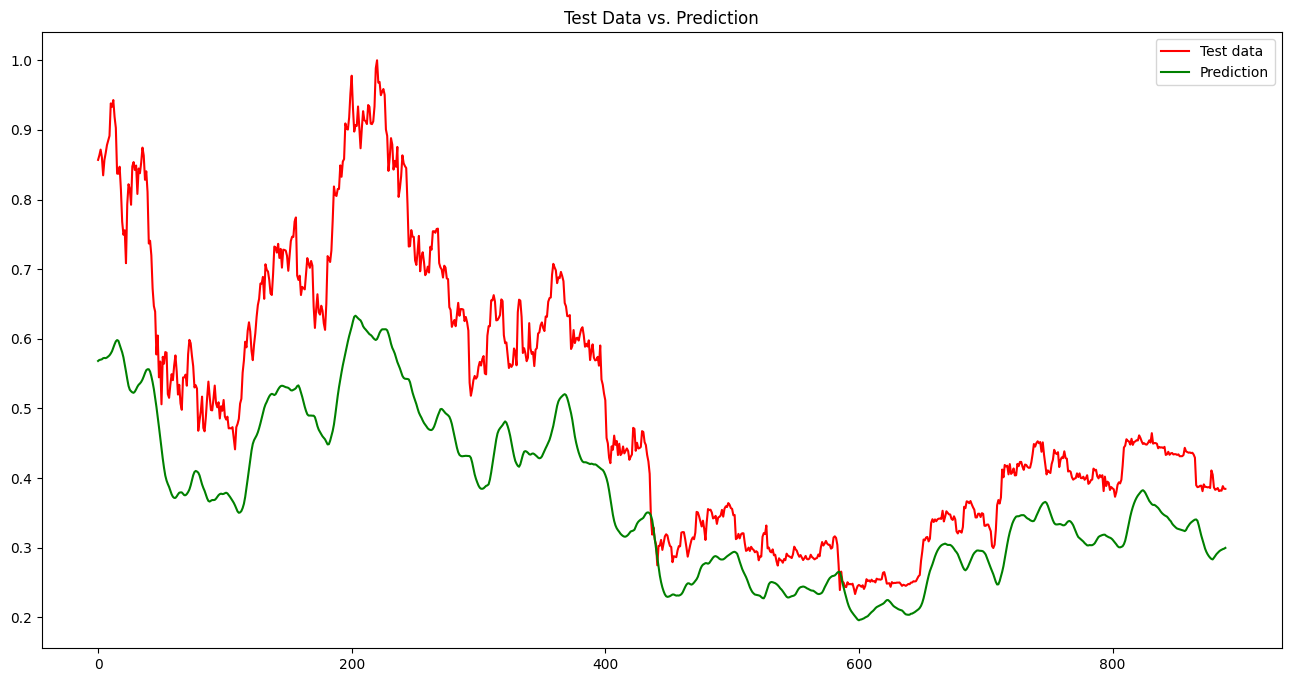

In [53]:
y_pred = regressor.predict(X_test)

plt.figure(figsize=(16,8), dpi= 100, facecolor='w', edgecolor='k')

plt.plot(y_test, color='red', label = 'Test data')
plt.plot(y_pred, color='green', label = 'Prediction')
plt.legend(loc='best')
plt.title('Test Data vs. Prediction')
plt.show()

In [46]:
mape = mean_absolute_percentage_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'mean_absolute_percentage_error = {mape}')
print(f'mean_absolute_error = {mae}')
print(f'mean_square_error = {mse}')

mean_absolute_percentage_error = 0.23486730400197087
mean_absolute_error = 0.12883710111001678
mean_square_error = 0.023541078243386852


Podemos apreciar como el GridSearch ha optimizado nuestros hiperparámetros y proporcionado un mejor rendimiento para nuestro modelo de redes neuronales LSTM.

*We can see how the GridSearch has optimized our hyperparameters and provided better performance for our LSTM neural network model.*